# Classifying Plant Diseases

In [1]:
from fastai.vision import *

In [2]:
path = Path('data/PlantVillage-Dataset')
path.ls()

[PosixPath('data/PlantVillage-Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus'),
 PosixPath('data/PlantVillage-Dataset/models'),
 PosixPath('data/PlantVillage-Dataset/Tomato___Leaf_Mold'),
 PosixPath('data/PlantVillage-Dataset/Potato___Early_blight'),
 PosixPath('data/PlantVillage-Dataset/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'),
 PosixPath('data/PlantVillage-Dataset/Tomato___Early_blight'),
 PosixPath('data/PlantVillage-Dataset/Tomato___Septoria_leaf_spot'),
 PosixPath('data/PlantVillage-Dataset/.ipynb_checkpoints'),
 PosixPath('data/PlantVillage-Dataset/Tomato___Spider_mites Two-spotted_spider_mite'),
 PosixPath('data/PlantVillage-Dataset/Potato___healthy'),
 PosixPath('data/PlantVillage-Dataset/Corn_(maize)___Common_rust_'),
 PosixPath('data/PlantVillage-Dataset/Tomato___Late_blight'),
 PosixPath('data/PlantVillage-Dataset/Tomato___Target_Spot'),
 PosixPath('data/PlantVillage-Dataset/Corn_(maize)___healthy'),
 PosixPath('data/PlantVillage-Dataset/Tomato___healthy'),
 Posi

In [3]:
import glob
import os
folders = []
for item in glob.glob('data/PlantVillage-Dataset/*'):
    folders.append(os.path.basename(item))

folders[:5]

['Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'models',
 'Tomato___Leaf_Mold',
 'Potato___Early_blight',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot']

In [4]:
# Remove Images that cannot be opened
for c in folders:
    print(c)
    verify_images(path/c, delete=True)

In [4]:
# Create Databunch
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=256, num_workers=4).normalize(imagenet_stats)

In [5]:
data.classes

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

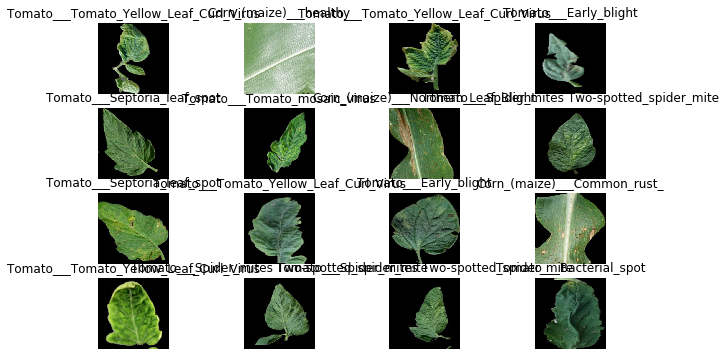

In [11]:
data.show_batch(rows=4, figsize=(10,6))

# Train Model

In [6]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.420694,0.272858,0.090025,03:06
1,0.232527,0.162096,0.055877,02:08
2,0.158390,0.107838,0.037459,02:07
3,0.093815,0.091384,0.032285,02:06


In [14]:
learn.save('stage-1')

In [7]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (19332 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_Yellow_Leaf_Curl_Virus
Path: data/PlantVillage-Dataset;

Valid: LabelList (4832 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Potato___Late_blight,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Bacterial_spot,Tomato___Septoria_leaf_spot,Tomato___Tomato_Yellow_Leaf_Curl_Virus
Path: data/PlantVillage-Dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU

In [8]:
learn.unfreeze()

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


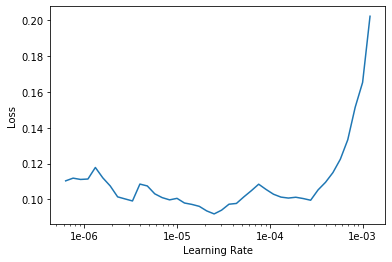

In [10]:
lr_find(learn)
learn.recorder.plot()

In [11]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.078915,0.099159,0.034975,02:40
1,0.068440,0.074489,0.025041,02:12


In [12]:
learn.save('stage-2')

# Interpretation

In [13]:
learn.load('stage-2');

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

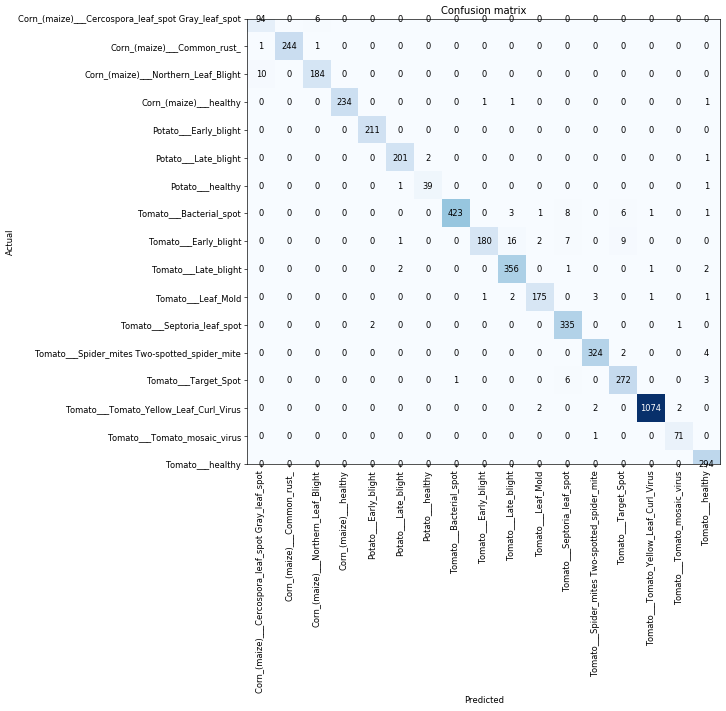

In [15]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Putting Model Into Production

In [16]:
learn.export()

In [17]:
defaults.device = torch.device('cpu')

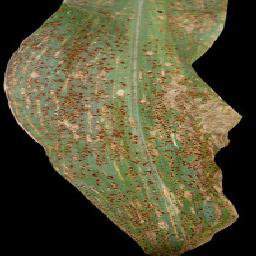

In [18]:
img = open_image(path/'Corn_(maize)___Common_rust_'/'04e947e8-d422-4f48-aa85-a1ec83883465___RS_Rust 2198_final_masked.jpg')
img

In [19]:
learn = load_learner(path)

In [20]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Corn_(maize)___Common_rust_

What the API Might look like:

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)